In [27]:
import os
import csv
import sys
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [5]:
ll ../results

total 2224
-rw-r--r--  1 nick  staff  567000 Apr 12 07:49 test_pred_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  567000 Apr 11 22:23 test_pred_222_24_5_1e-06.csv


In [6]:
resultspath = '../results/test_pred_222_24_25_1e-06.csv'
res = pd.read_csv(resultspath, header=None)
res.head()

,0,1
0,9.682445,0.000000
1,7.316693,0.025241
2,8.175137,0.000000
3,9.393465,0.000000
4,9.488214,0.000000


In [7]:
datapath = '../data/clinical_bert_reference_set.txt'
df = pd.read_csv(datapath)
df.head()

,drug,llt_id,llt,class,string
0,Cimzia,35104113,pancytopenia,is_event,"pancytopenia arthralgia (6% cimzia, 4% placebo..."
1,Cimzia,35104746,lymphadenopathy,is_event,"lymphadenopathy and arthralgia (6% cimzia, 4% ..."
2,Cimzia,35104868,leukopenia,is_event,"leukopenia patients, and arthralgia (6% cimzia..."
3,Cimzia,35122651,anemia,is_event,"anemia placebo-treated patients, and arthralgi..."
4,Cimzia,35122884,cytopenia,not_event,"cytopenia (6% cimzia, 4% placebo). other adver..."


In [9]:
np_random_seed = int(resultspath.split('_')[2])
random_state = int(resultspath.split('_')[3])
EPOCHS = int(resultspath.split('_')[4])
LR = resultspath.split('_')[5].split('.')[0]

print(f" np_random_seed: {np_random_seed}")
print(f" random_state: {random_state}")
print(f" EPOCHS: {EPOCHS}")
print(f" LR: {LR}")

 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06


In [10]:
labels = {'not_event': 0, 'is_event': 1}

In [43]:
druglist = sorted(set(df['drug']))

random.seed(np_random_seed)
random.shuffle(druglist)

drugs_train, drugs_val, drugs_test = np.split(druglist, [int(0.8*len(druglist)), int(0.9*len(druglist))])

len(drugs_train), len(drugs_val), len(drugs_test)

df_train = df[df['drug'].isin(drugs_train)]
df_val = df[df['drug'].isin(drugs_val)]
df_test = df[df['drug'].isin(drugs_test)]

df_train.shape, df_val.shape, df_test.shape

((88369, 5), (11818, 5), (13210, 5))

In [44]:
test_y = [labels[l] for l in df_test['class']]
len(test_y), sum(test_y)

(13210, 1701)

In [45]:
auroc = roc_auc_score(test_y, res[1])
auroc

ValueError: Found input variables with inconsistent numbers of samples: [13210, 11340]

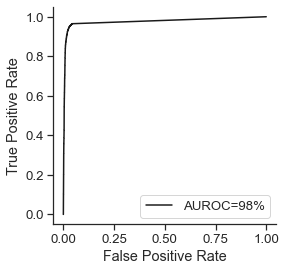

In [14]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(4,4))
fpr, tpr, thresholds = metrics.roc_curve(test_y, res[1])
plt.plot(fpr, tpr, 'k-', label='AUROC=%.0f%%' % (100*auroc))
# plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
sns.despine()

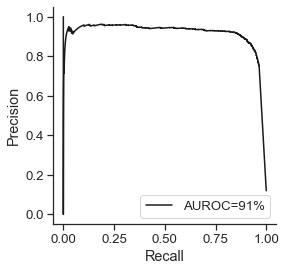

In [15]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(4,4))
precision, recall, thresholds = metrics.precision_recall_curve(test_y, res[1])
plt.plot(recall, precision, 'k-', label='AUROC=%.0f%%' % (100*metrics.auc(recall, precision)))
# plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
sns.despine()

In [16]:
df_test['Pred0'] = res[0].to_numpy()
df_test['Pred1'] = res[1].to_numpy()
df_test['PredEvent'] = (df_test['Pred1'] > df_test['Pred0'])

In [17]:
df_test.head()

,drug,llt_id,llt,class,string,Pred0,Pred1,PredEvent
106100,Pristiq,36367466,se,not_event,se controlled studies pristiq placebo 50 mg 10...,9.682445,0.000000,False
103935,ADCETRIS,35809243,pain,is_event,pain (5%) in the adcetris-treated arm and 5 pa...,7.316693,0.025241,False
66038,ZERBAXA,36045065,hypersensitivity reaction,not_event,hypersensitivity reaction 6 adverse reactions ...,8.175137,0.000000,False
46417,Breo,36367466,se,not_event,se reactions are reported voluntarily from a p...,9.393465,0.000000,False
12369,ONGLYZA,36367397,p,not_event,p roval use of onglyza. because these reaction...,9.488214,0.000000,False


In [18]:
df_test['PredEvent'].sum(), sum(test_y)

(1358, 1361)

In [19]:
pd.crosstab(index=df_test['class'], columns=df_test['PredEvent'])

PredEvent,False,True
class,,
is_event,138,1223
not_event,9844,135


## Label by label analysis

In [20]:
drugs = set(df_test['drug'])
len(drugs)

200

In [24]:
df[df['drug'] == 'Folotyn'].head()

,drug,llt_id,llt,class,string
95336,Folotyn,35104113,pancytopenia,is_event,pancytopenia a serious adverse event while on ...
95337,Folotyn,35104461,lymphoma,not_event,lymphoma labeling: * bone marrow suppression [...
95338,Folotyn,35104590,t-cell lymphoma,not_event,t-cell lymphoma labeling: * bone marrow suppre...
95339,Folotyn,35104691,thrombocytopenia,is_event,thrombocytopenia and precautions ( 5.1 )] * mu...
95340,Folotyn,35104691,thrombocytopenia,is_event,"thrombocytopenia , nausea, and fatigue. excerp..."
